In [2]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
import seaborn as sns
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
sns.set_style('white')
sns.set_context('paper')

import glob
locations = glob.glob('/export/d0/kitouni/data/experiments/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

In [3]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

<All keys matched successfully>

In [4]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y)
X, y = X[mask], y[mask]

acts = get_penultimate_acts(model, X)

In [5]:
pca = PCA(n_components=10)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

[9.6412402e-01 1.1718512e-02 5.5348151e-03 2.1339087e-03 1.8239800e-03
 1.4211735e-03 7.6872855e-04 6.8818923e-04 5.2764703e-04 4.5382525e-04]


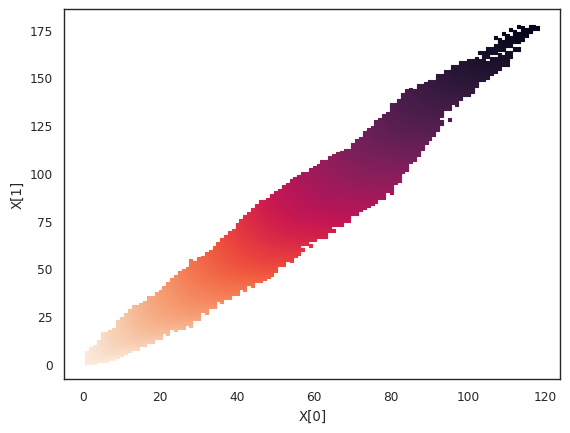

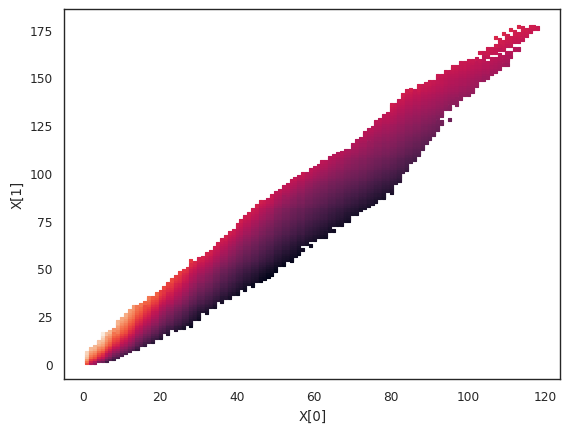

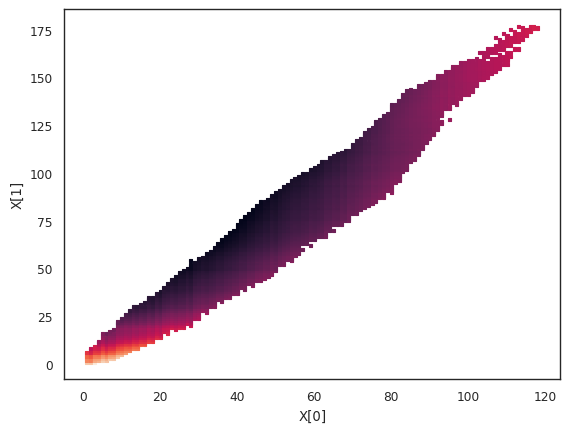

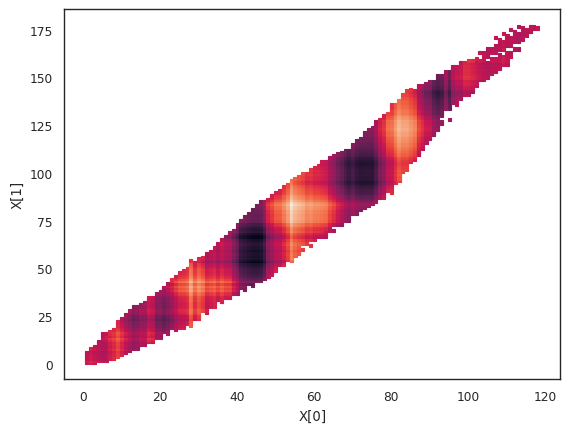

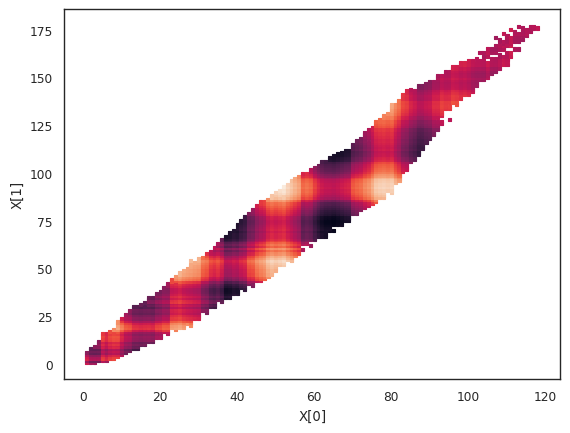

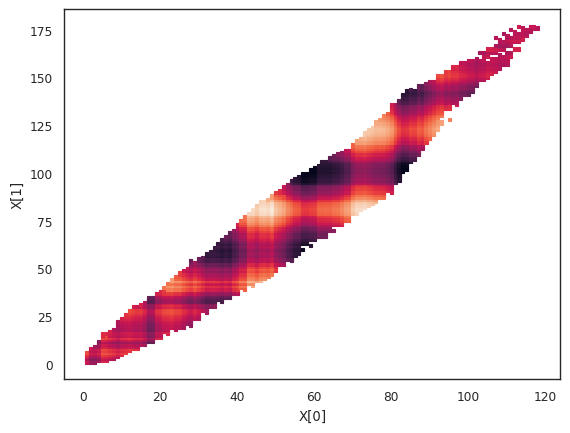

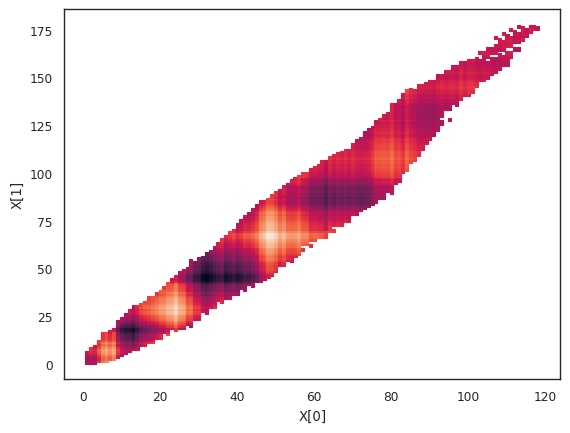

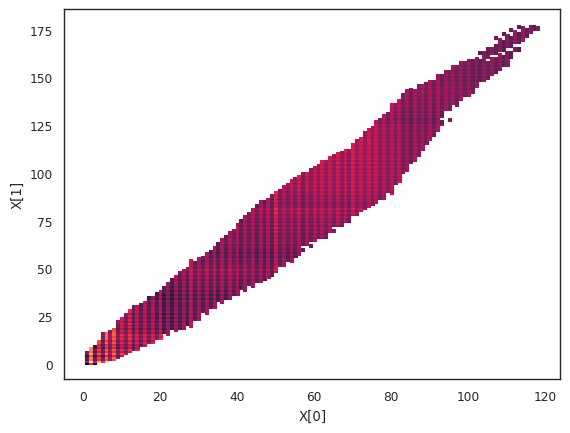

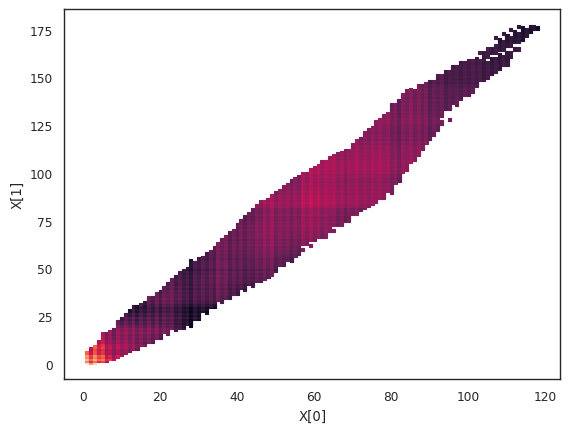

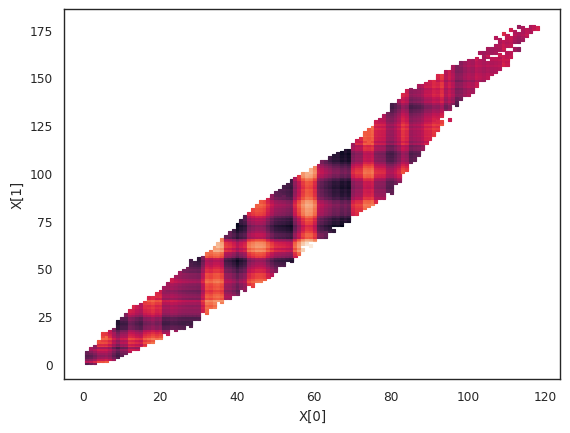

In [6]:
# visualize PCs as a function of X[0] and X[1]
for i in range(pca.n_components_):
    plt.scatter(X[:, 0], X[:, 1], c=acts_pca[:, i], s=5, marker='s')
    plt.xlabel(f"X[0]")
    plt.ylabel(f"X[1]")
    plt.show()

In [7]:
from pysr import PySRRegressor
from functools import partial

sr_factory = partial(PySRRegressor,
    niterations=200,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
        "parity(x) = x % 2",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    ncyclesperiteration=300,
)

In [49]:
# catch warnigns
import warnings
import tqdm
import pickle
import time
FORCE = False

os.makedirs(f"plots/long-runs/{model_name}/equations", exist_ok=True)
inputs = X[:, :2].detach().cpu().numpy()
# fit the symbolic regression model to the data
equations = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(tqdm.tqdm(acts_pca.T)):
        time.sleep(2)
        fname = f"plots/long-runs/{model_name}/equations/{i}.pkl"
        if not os.path.exists(fname) or FORCE:
            sr = sr_factory()
            sr.fit(inputs, feature)
            equations.append(sr)
            # pickle.dump(sr, open(fname, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
        else:
            equations.append(pickle.load(open(fname, 'rb')))

        # make predictions
        lowest_loss_idx = equations[-1].equations_.loss.argmin()
        y_pred = equations[-1].predict(inputs, lowest_loss_idx)
        recomputed_loss = ((feature - y_pred)**2).mean()

        loss = equations[-1].equations_.loss[lowest_loss_idx]
        print(f"Loss: {loss} vs {recomputed_loss}, var: {np.var(feature)}")
print("Done")

 10%|█         | 1/10 [00:02<00:18,  2.04s/it]

Loss: 0.01327427 vs 0.013274278768118663, var: 23.386301040649414


 20%|██        | 2/10 [00:04<00:16,  2.03s/it]

Loss: 0.010952879 vs 0.010952892633274609, var: 0.28425100445747375


 30%|███       | 3/10 [00:06<00:14,  2.02s/it]

Loss: 0.0040708035 vs 0.004070808042351689, var: 0.13425536453723907


 40%|████      | 4/10 [00:08<00:12,  2.02s/it]

Loss: 0.010579419 vs 0.010579413354184037, var: 0.05176123231649399


 50%|█████     | 5/10 [00:10<00:10,  2.02s/it]

Loss: 0.007133261 vs 0.007133275896992783, var: 0.04424348101019859


 60%|██████    | 6/10 [00:12<00:08,  2.02s/it]

Loss: 0.006415032 vs 0.006415049862224377, var: 0.034472737461328506


 70%|███████   | 7/10 [00:14<00:06,  2.02s/it]

Loss: 0.004704276 vs 0.004704272038661593, var: 0.018646707758307457


 80%|████████  | 8/10 [00:16<00:04,  2.02s/it]

Loss: 0.0030466046 vs 0.0042258041318470165, var: 0.016693096607923508


 90%|█████████ | 9/10 [00:18<00:02,  2.01s/it]

Loss: 0.002523411 vs 0.002523419227923262, var: 0.012798878364264965


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]

Loss: 0.0059130536 vs 0.005912913619679079, var: 0.01100822351872921
Done


In [11]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds_from_acts(acts):
    pred = model.readout(acts)
    pred = inverse_transform(pred, data)
    return pred[:, 0]



In [24]:
# combine the predictions of the symbolic regression models
# into a vector of features and use the same linear regression parameters from before
# to predict the output
sr_features = np.zeros((len(inputs), len(equations)))

for i, (sr, feat) in enumerate(zip(equations, acts_pca.T)):
    # idx = sr.equations_.score.values.argsort()[::-1][0] # select the best pareto front
    # idx = sr.equations_.loss.values.argsort()[0] # select the best equation by loss
    # pred = sr.predict(inputs, idx)
    pred = sr.predict(inputs)
    print((((pred - feat)**2).mean()), feat.std()**2)
    sr_features[:, i] = pred
sr_features = torch.tensor(sr_features, device=args.DEV).float()

print()
# We will get predictions in three different ways:
# 1. use the model readout layer
# 2. use a linear regression directly to the target
# 3. use a linear regression from the original PCA features

# 1. use the model readout layer
sr_features[:, 1:] = 0
acts = pca.inverse_transform(sr_features.detach().cpu().numpy())
acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print("Model readout layer", (pred - y).pow(2).mean().sqrt().item())


# 2. use a linear regression directly to the target
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(sr_features.detach().cpu().numpy(), y.detach().cpu().numpy())
pred = lr.predict(sr_features.detach().cpu().numpy())
print("Linear regression", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)

0.013402055335377213 23.38630072772594
0.24182181043425263 0.0
0.13018379996605542 0.0
0.04063427915923774 0.0
0.033766134514868554 0.0
0.026956610952159635 0.0
0.013445481374146293 0.0
0.01317375430363284 0.0
0.010082577492527533 0.0
0.0024927282059464145 0.0

Model readout layer 16820.352258997522
Linear regression 16819.147184087546


In [44]:
sr.equations_.best

AttributeError: 'DataFrame' object has no attribute 'best'

In [23]:
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
acts_pca[:, 1:] = 0
acts = pca.inverse_transform(acts_pca)

acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print((pred - y).pow(2).mean().sqrt())

tensor(12311.7455, dtype=torch.float64, grad_fn=<SqrtBackward0>)


In [22]:
# now let's do direct SR on the final target
sr = sr_factory()
sr.fit(inputs, y.detach().cpu().numpy())


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/julia_helpers.py:162: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before* importing `torch`. For updates, see https://github.com/pytorch/pytorch/issues/78829
  warnings.warn(


Compiling Julia backend...


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(


Started!

Expressions evaluated per second: 9.670e+04
Head worker occupation: 46.3%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 227 / 3000 total iterations (7.567%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.576e+11  1.594e+01  y = 1.1005e+06
3           7.320e+09  1.780e+00  y = (x₀ * 19103)
5           3.231e+09  4.089e-01  y = ((x₁ + x₀) * 7835.9)
7           2.046e+09  2.283e-01  y = (((x₁ + 10.519) + x₀) * 7385.1)
9           5.071e+08  6.976e-01  y = ((x₀ + x₁) * (8978 + (-9.9199 * x₁)))
11          5.070e+08  6.769e-05  y = (((x₀ + x₁) * (8977.4 + (-9.9201 * x₁))) + x₁)
12          5.007e+08  1.247e-02  y = ((x₀ + (x₁ + inv(-1.5453))) * (8978 + (-9.9199 * x₁)))
13          4.812e+08  3.969e-02  y = (((89915 + (-80971 + (-27.911 * x₁))) * x₀) + (x₁ * 9190.5...
          

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        1.1004751e6   
	1         1.780376                                   (x0 * 19102.855)   
	2         0.408950                            ((x0 + x1) * 7835.8755)   
	3         0.228329               (((x1 + 10.518941) + x0) * 7385.087)   
	4         0.750234        ((x0 + x1) * (9131.974 + (-16.49671 * x0)))   
	5   >>>>  0.172296  ((x0 + x1) * (8581.896 + ((-0.1130343 * x0) * ...   
	6         0.055644  (((x0 + -2.1303892) + x1) * (8767.921 + ((-0.1...   
	7         0.000083  ((((x0 + -2.1303892) + x1) * (8767.921 + ((-0....   
	8         0.000089  (((x0 + -2.1303892) + x1) * (8767.921 + ((sin(...   
	9         0.000169  (((x0 + -2.1303892) + x1) * (8767.921 + ((sin(...   
	10        0.022551  (((x0 + -2.1303892) + x1) * (8767.921 + ((-0.1...   
	11        0.003472  ((((x0 + -2.1303892) + parity(inv(x0 * -0.1260...   
	
	            loss  complexity  
	0   2.575917e+11           1  
	1   7.320104e+09           3  
	2   3.230785e+09           5  
	3   2.046369e+09           7  
	4   4.563933e+08           9  
	5   3.233591e+08          11  
	6   2.893034e+08          13  
	7   2.892556e+08          15  
	8   2.892298e+08          16  
	9   2.891809e+08          17  
	10  2.827326e+08          18  
	11  2.807763e+08          20  
]

In [27]:
pred = sr.predict(inputs, sr.equations_.loss.argmin())
print("SR", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)

SR 2259288.174457114


In [29]:
# semf rms
Z, N = inputs.T
preds = (semi_empirical_mass_formula(Z, N))* (N+Z)
print("SEMF", ((preds - y.detach().cpu().numpy())**2).mean()**0.5)

SEMF 7928.02400004463


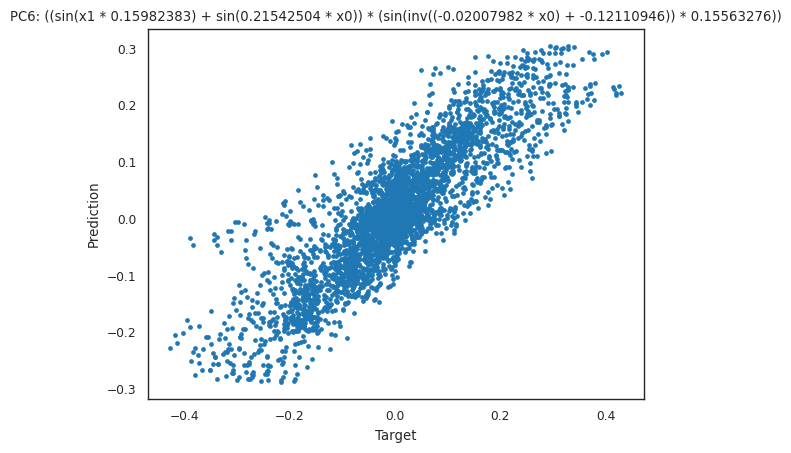

In [48]:
pc_idx = 6
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
idx = sr.equations_.loss.argmin()
function = equations[pc_idx].equations_.equation[idx]
preds = equations[pc_idx].predict(inputs, idx)
tgt = acts_pca[:, pc_idx]
plt.plot(tgt, preds, '.')
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"PC{pc_idx}: " + function)
plt.show()